In [103]:
import pandas as pd
import numpy as np
import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed 
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings("ignore")

In [17]:
returns = pd.read_pickle("./Data/returns.pkl")
returns = returns.iloc[1:]
returns.head()

,905270,921795,904261,905261,916328,923024,936365,902355,912215,929813,...,9660J1,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
date,,,,,,,,,,,,,,,,,,,,,
1990-01-03,-0.835165,-0.475059,5.000000,-0.810537,0.361421,0.000000,-3.030303,0.000000,-0.431034,-1.315789,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,-0.797872,-1.272872,2.380952,-1.634321,-0.180060,3.454545,-1.562500,0.530612,0.225108,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,-2.546917,1.531023,-0.372093,-1.661475,-1.079730,1.054482,-3.174603,0.487211,-0.656531,-1.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,2.017423,-0.873016,0.000000,2.534319,0.000000,0.000000,0.000000,1.010101,0.434783,3.405405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-09,-1.123596,-2.962370,-0.404606,-1.098524,-0.364707,-1.043478,1.639344,0.000000,0.432900,-3.293257,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# dropping columns with all NaN
drop_columns = []

for col in returns.columns:
    if returns[col].isnull().all() == True:
        drop_columns.append(col)
        
returns.drop(columns=drop_columns, inplace=True)

In [64]:
# From Integrated Model Linear
def get_investable(t, n):
    """ Find stocks in investable universe at time t+1
    (stocks in the S&P500 that have prices recorded for the last n days)"""
    
    df_investable = returns.copy(deep = True).sort_index(ascending = False)
    
    #add 1 date to get the test features in investable
    t = t + pd.DateOffset(1)
    n += 1
    
    #if t is now a non-trading day, advance until we reach a valid trading day
    while t not in df_investable.index:
        t = t + pd.DateOffset(1)
    
    t_index = df_investable.index.get_loc(t)
    
    #take n_rows worth of data upto time specified
    df_investable = df_investable.iloc[t_index:t_index + n]
    
    #find all stocks that exist in the S&P at this time period
    investable_universe = []
    for col in df_investable.columns:
        if ~df_investable[col].iloc[:n].isna().any():
            investable_universe.append(col)
        
    df_investable = df_investable[investable_universe]
    
    return df_investable

In [75]:
# all stocks starting May 22 to 504 days before with stock returns listed
t = pd.to_datetime("2020-02-25")
get_investable(t, 280)

,916328,936365,905271,905113,905802,905425,906156,916305,992816,921093,...,311917,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
date,,,,,,,,,,,,,,,,,,,,,
2020-02-26,0.283496,-0.168173,0.012739,0.441460,-2.631120,-0.753794,-1.985112,-0.530504,1.586226,-1.385110,...,1.149372,-2.639047,-0.256769,1.905697,-0.194482,-7.514811,-1.117365,3.317491,-7.587199,-0.867906
2020-02-25,-4.135649,-3.155537,-4.089113,-4.112718,-4.699435,-1.869252,-5.686871,-1.006565,-3.387216,-5.581504,...,-3.143786,-4.063373,-3.230178,-7.889975,-0.801833,-10.767947,-2.595937,-4.850151,-11.700270,-3.014745
2020-02-24,-3.224700,-7.807808,-3.702396,-1.195098,-6.519714,-1.641923,-4.974055,-5.967078,-4.750040,-2.460137,...,-2.020070,-7.459489,-2.467504,-6.481638,-6.091830,-4.945782,-4.950192,-2.934848,-7.530828,-3.530293
2020-02-21,-1.141759,-6.966998,-0.168363,-0.682511,-0.463535,-0.654425,-1.230048,-2.409639,-2.263503,-0.746100,...,-1.364204,0.176838,-1.604162,0.595846,-4.036727,-0.943149,-3.189911,-0.666838,-1.943285,-1.020350
2020-02-20,-1.007162,-2.767402,-0.164178,-1.085978,1.809029,-1.082126,-0.255605,0.789314,-1.025895,0.591312,...,-0.471153,-1.963115,0.348053,2.656414,-1.813720,2.884097,-0.111152,0.610700,0.028798,-1.631715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-22,0.098012,-4.862783,-0.573698,-15.978218,-1.779966,0.381128,-0.646895,-1.811594,-2.244612,-1.581563,...,-0.491320,-1.105174,-2.814977,0.918836,-3.037589,-1.910569,-2.104221,-1.205700,-1.622352,-1.358946
2019-01-18,1.276234,2.567901,1.692525,0.792604,1.871142,0.118421,0.995075,2.009702,0.615937,1.958074,...,1.233504,-12.971121,2.607964,-4.252199,1.769984,1.026694,2.084913,1.126917,3.353517,0.641621
2019-01-17,1.002578,2.635580,0.879576,0.397879,1.092044,0.369783,0.080475,0.370971,0.593778,0.254042,...,1.679029,0.364109,1.393233,2.095808,1.005108,1.882845,1.021190,1.045361,0.585617,1.213364


In [21]:
# Converts investable dataframe into 3D tensor for input into RNN fitting
# Eg. if investable_df has shape (52, 635), it is converted to a numpy array of shape (52, 1, 635)

def formatX(investable_df):
    train_values = []
    # Iterates through each day in investable df and appends feature values to train_values
    for i in range(len(investable_df.index)):
        train_values.append(investable_df.iloc[i].values)
    train_values = np.array(train_values) # converts to numpy array
    train_values = np.reshape(train_values, (train_values.shape[0], 1, train_values.shape[1])) # reshapes to 3-dimensional
    return train_values

In [22]:
formatX(get_investable(t, 80))

array([[[-3.22469983, -7.80780781, -3.70239636, ..., -2.93484809,
         -7.53082795, -3.53029256]],

       [[-1.14175899, -6.96699843, -0.16836335, ..., -0.66683765,
         -1.94328487, -1.02035   ]],

       [[-1.00716204, -2.76740238, -0.16417794, ...,  0.61070015,
          0.0287977 , -1.6317147 ]],

       ...,

       [[-0.47613379,  2.41472985, -1.60107046, ...,  4.21927269,
          0.9470124 , -1.94628847]],

       [[ 0.67106052,  0.30275507, -0.50041319, ...,  1.33406233,
         -1.1589035 ,  0.10572421]],

       [[ 0.95572224, -1.95903829,  2.99791943, ..., -1.93029491,
         -0.46583851,  0.94526605]]])

In [23]:
# Formats output for a stock as a np array
# Takes in a stock, a date, and a number of rows to look back on and formats the output values as a numpy array
# Eg. formatY(stockX, Feb.25, 80) outputs the returns for stockX starting from 80 days before Feb.25 up to Feb.25

def formatY(stock, t, n_rows):
    t_index = returns.index.get_loc(t)
    return returns[stock].iloc[t_index - n_rows:t_index + 1].shift(-1).iloc[:-1].values[::-1]

In [24]:
formatY("916328", t, 80)

array([-4.1356493 , -3.22469983, -1.14175899, -1.00716204,  0.54005401,
       -0.86995316,  1.10509698, -0.12388783, -0.42615229,  0.98527746,
        0.48935928, -1.78830893, -0.10049129,  1.50742378,  1.34390076,
       -0.09180629, -2.26558995,  0.02243662, -0.44672772, -0.0558098 ,
       -0.8960177 , -0.36371652, -1.23013281,  2.37378803,  0.82022472,
        0.81558677,  1.02998398,  1.91275951,  0.72838346, -0.28116214,
       -1.24942156,  0.2667904 ,  0.40764034, -0.55594163,  0.52392595,
       -1.21909143,  0.10361501,  0.06912442, -0.68649886,  0.13748854,
        0.        , -0.08013738,  0.79621509, -0.78992559,  0.48314736,
       -0.14932231,  0.76388889,  0.05790388,  0.44201466,  1.24838064,
        0.41390728,  0.8227018 , -1.88348152,  0.28155795,  0.07043907,
        0.97202466, -0.17749379, -1.10005851,  0.03512058,  0.        ,
        1.10072198,  0.89562933,  0.07170172, -0.25032781, -0.47455214,
        0.03560408, -1.69175125,  1.89015692, -0.11873664, -0.14

In [39]:
# Similar to get_model in simpleRNN-2

def LSTM_autoencoder(stock, investable_df):
    # Converts features and output values to a 3D tensor and numpy array respectively
    convertedX = formatX(investable_df)
    t_index = returns.index.get_loc(investable_df.index[0])
    t = returns.index[t_index + 1]
    convertedY = formatY(stock, t, len(investable_df.index))
    
    # Build LSTM model with autoencoder
    model = Sequential()
    model.add(LSTM(100,activation='relu', input_shape =(convertedX.shape[1], convertedX.shape[2])))
    model.add(RepeatVector(convertedX.shape[1]))
    model.add(LSTM(100,activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer="adam", loss='mse')#rnn: optimizer='rmsprop'
    
    # Fit model on formatted data
    history = model.fit(convertedX, convertedY, validation_split=0.2, epochs=50, batch_size=16, verbose=0)
    history
    #model.fit(convertedX, convertedY, validation_split=0.2, epochs=50, batch_size=16, verbose=0)
    
    
    #plot_model(model, show_shapes=True, to_file='reconstruct_lstm_autoencoder.png')
    # demonstrate recreation
    #yhat = model.predict(convertedX, verbose=0)
    #print(yhat[0,:,0])
    
    return model, history

In [99]:
# Test run on LSTM with autoencoder
model = LSTM_autoencoder("916328", investable.loc[tts:])[0]

In [76]:
t = pd.to_datetime("2021-05-25")
test_size = 40
look_back = 240
investable = get_investable(t, look_back + test_size)

tts = investable.index[test_size]
investable.loc[tts:]

,916328,936365,905271,905113,905802,905425,906156,916305,992816,921093,...,311917,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
date,,,,,,,,,,,,,,,,,,,,,
2021-03-30,-2.028962,-1.477833,-0.478889,0.761421,-0.795978,-1.293103,0.786683,1.631602,-1.227449,1.418812,...,-0.323134,3.980124,1.009564,5.951878,0.602014,4.714388,1.869785,4.819590,5.688986,1.770631
2021-03-29,0.131072,-0.348792,-1.131537,-1.469209,-0.981748,1.000118,-0.946219,-0.512601,0.148503,-1.415990,...,0.473849,-1.199269,0.776439,-6.529888,-2.971764,-7.853256,-2.442211,-4.081793,-5.815149,-1.767116
2021-03-26,2.536749,1.561270,3.588560,2.041467,4.887600,0.318697,1.019117,0.688172,0.514139,1.810830,...,1.971693,-3.385422,3.333794,2.417834,5.847727,-1.995402,4.019654,4.986214,0.678629,2.159957
2021-03-25,0.872733,-0.339958,-0.266177,3.294893,-0.188188,-0.317684,2.788614,3.356301,0.416354,1.716738,...,-1.426080,1.605645,1.917383,0.337883,0.178283,4.507015,2.151858,1.397905,4.873341,2.078129
2021-03-24,-2.049963,-2.424088,1.208672,-0.065854,3.166069,0.413516,1.719577,0.022232,-1.999347,0.647948,...,-0.237541,-4.816042,-0.365220,-5.122780,-1.695872,-6.939725,-2.264899,-2.203840,-1.997872,-1.462701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-22,1.520468,5.668934,3.399392,2.266289,8.276052,3.067782,1.251227,0.044944,2.880352,1.142857,...,3.063434,6.609758,1.578283,7.687975,4.318862,-2.137067,9.869233,2.687201,-1.702685,1.525248
2020-04-21,-4.030612,-7.109005,-3.256053,-9.020619,1.224603,-0.530696,-2.963933,-6.315789,-3.091034,-3.687397,...,-3.569937,-7.990849,-1.980198,-8.972058,-3.853878,-2.162942,-6.505190,-5.253094,-4.978220,-6.377374
2020-04-20,2.072701,0.653710,-3.218962,-0.085837,-3.801874,-4.017134,-3.867719,-3.061224,-2.075672,-2.285561,...,-3.612033,-0.998819,-0.431300,0.128337,-0.828982,-1.421464,-3.848287,0.060417,-3.772455,-0.496620


In [104]:
# Predicts stock price at a given date

# Number of days to look back at when training model
look_back = 80

def pred_date(stock, date):
    investable = get_investable(date, look_back + 1)
    
    # Checking for invalid inputs
    if stock not in investable.columns:
        print(stock + " is not in the investable universe")
        return
    if investable.shape[0] == 0:
        print("Investable universe is empty")
        return
    
    ''' investable.iloc[0:1] is the first row of the investable df 
    (i.e. the row we're using to predict the stock's return at time date) '''
    convertedX = formatX(investable.iloc[0:1])
    
    ''' We train the model on the day before date (the parameter) so that the date we're predicting
    for is not included in the training set'''
    model = LSTM_autoencoder(stock, investable.iloc[1:])[0]
    
    return model.predict(convertedX)[0, 0]

In [106]:
pred_date("916328", t)[0]

0.07156887

In [108]:
# Predicts returns for all stocks in the investable universe at a given date
def pred_date_all(date):
    investable = get_investable(date, look_back)
    df = pd.DataFrame()
    stocks = []
    predictions = []
    count = 0 # used to keep track of progress when running function
    for stock in investable.columns:
        stocks.append(stock)
        predictions.append(pred_date(stock, date)[0])
        count += 1
        percent = count / len(investable.columns)
        print(str(percent * 100) + "% ")
    df["stock"] = stocks
    df["pred_" + date.strftime("%Y-%m-%d")] = predictions
    return df

In [ ]:
# 7:45am EST
pred_t = pred_date_all(t)

0.15873015873015872% 
0.31746031746031744% 
0.4761904761904762% 
0.6349206349206349% 
0.7936507936507936% 
0.9523809523809524% 
1.1111111111111112% 
1.2698412698412698% 
1.4285714285714286% 
1.5873015873015872% 
1.746031746031746% 
1.9047619047619049% 
2.0634920634920633% 
2.2222222222222223% 
2.380952380952381% 
2.5396825396825395% 
2.6984126984126986% 
2.857142857142857% 
3.015873015873016% 
3.1746031746031744% 
3.3333333333333335% 
3.492063492063492% 
3.650793650793651% 
3.8095238095238098% 
3.968253968253968% 
4.1269841269841265% 
4.285714285714286% 
4.444444444444445% 
4.603174603174604% 
4.761904761904762% 
4.920634920634921% 
5.079365079365079% 
5.238095238095238% 
5.396825396825397% 
5.555555555555555% 
5.714285714285714% 
5.873015873015873% 
6.031746031746032% 
6.190476190476191% 
6.349206349206349% 
6.507936507936509% 
6.666666666666667% 
6.825396825396825% 
6.984126984126984% 
7.142857142857142% 
7.301587301587302% 
7.4603174603174605% 
7.6190476190476195% 
7.777777777777778

64.60317460317461% 
64.76190476190476% 
64.92063492063492% 
65.07936507936508% 
65.23809523809524% 
65.39682539682539% 
65.55555555555556% 
65.71428571428571% 
65.87301587301587% 
66.03174603174602% 
66.19047619047619% 
66.34920634920634% 
66.5079365079365% 
66.66666666666666% 
66.82539682539682% 
66.98412698412697% 
67.14285714285714% 
67.3015873015873% 
67.46031746031747% 
67.61904761904762% 
67.77777777777779% 
67.93650793650794% 
68.0952380952381% 
68.25396825396825% 
68.41269841269842% 
68.57142857142857% 
68.73015873015873% 
68.88888888888889% 
69.04761904761905% 
69.2063492063492% 
69.36507936507937% 
69.52380952380952% 
69.68253968253968% 
69.84126984126983% 
70.0% 
70.15873015873015% 
70.31746031746032% 
70.47619047619048% 
70.63492063492063% 
70.7936507936508% 
70.95238095238095% 
71.11111111111111% 
71.26984126984127% 
71.42857142857143% 
71.58730158730158% 
71.74603174603175% 
71.9047619047619% 
72.06349206349206% 
72.22222222222221% 
72.38095238095238% 
72.53968253968253% 

In [ ]:
pred_t

In [ ]:
df = pd.DataFrame()
predictions = []
actuals = []
dates = []
for date in investable.index[:test_size]:
    convertedX = formatX(investable.loc[[date]])
    prediction = model.predict(convertedX)[0, 0]
    actual = investable.loc[date, "916328"].item()
    predictions.append(prediction)
    actuals = np.append(actuals, actual)
    dates.append(date)

df["predictions"] = np.array(predictions)
df["actuals"] = actuals
df["date"] = dates
df.set_index("date", inplace=True)
df

dict_keys(['loss', 'val_loss'])


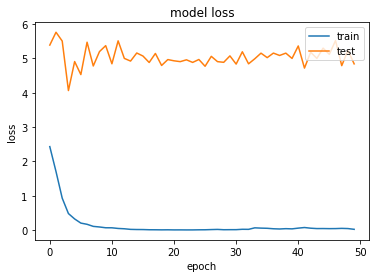

In [53]:
# get data to plot
history = LSTM_autoencoder("916328", investable.loc[tts:])[1]
print(history.history.keys())

# plot the loss history
# original
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()